
<img align="left" src = https://www.linea.gov.br/wp-content/themes/LIneA/imagens/logo-header.png width=120 style="padding: 20px"> <br> 

# Photo-z Parsl Afterburner
Last verified run: 07/27/2022


Disclaimer: preliminary version

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml
import os
import glob

%matplotlib inline 

#### Hardcoded paths (temporary)

In [20]:
config_path = "../sample-data/sample.yml"
input_paths = glob.glob('../sample-data/cats/*.parquet')
output_paths = glob.glob('../sandbox/data/outputs/*/photz-*.parquet')

To do: make output paths consistent (alphabetical/numeric)

### Configuration used

In [21]:
with open(config_path) as _file:
    phz_config = yaml.load(_file, Loader=yaml.FullLoader)
    settings = phz_config.get('settings', {})
settings

{'photo_type': 'MAG_AUTO_{}',
 'err_type': 'MAGERR_AUTO_{}',
 'bands': ['G', 'R', 'I', 'Z'],
 'partitions': 4,
 'index': 'ID',
 'lephare_bin': '/home/singulani/projects/lephare_dev/source'}

### Input data 

In [22]:
data = pd.read_parquet(input_paths[0])
for i in range(1,5):
    data = pd.concat([data, pd.read_parquet(input_paths[i])])

In [23]:
data.head()

,RA,DEC,MAG_AUTO_G,MAG_AUTO_R,MAG_AUTO_I,MAG_AUTO_Z,MAG_AUTO_Y,MAGERR_AUTO_G,MAGERR_AUTO_R,MAGERR_AUTO_I,MAGERR_AUTO_Z,MAGERR_AUTO_Y,ID
0,305.223205,-51.026690,25.324856,24.733845,24.516499,24.528694,99.000000,0.293505,0.237192,0.331101,0.606885,99.000000,937
1,305.073551,-51.032121,25.815676,25.627741,24.361727,22.863373,24.352261,0.549157,0.626758,0.372315,0.161827,2.380363,801
2,304.319299,-51.029541,23.144093,22.519281,22.001871,21.881752,23.319414,0.055370,0.043286,0.042170,0.079575,1.021063,131
3,305.189715,-51.030019,24.727598,23.948742,23.599569,23.187975,23.643391,0.240440,0.184837,0.213955,0.276530,1.611370,910
4,304.813333,-51.035065,24.063274,23.894133,23.715647,23.592186,23.413425,0.090046,0.108054,0.155564,0.256717,0.793663,558


In [24]:
data.describe()

,RA,DEC,MAG_AUTO_G,MAG_AUTO_R,MAG_AUTO_I,MAG_AUTO_Z,MAG_AUTO_Y,MAGERR_AUTO_G,MAGERR_AUTO_R,MAGERR_AUTO_I,MAGERR_AUTO_Z,MAGERR_AUTO_Y,ID
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,304.745990,-51.030985,28.596781,24.402389,22.923701,22.628118,35.177409,6.443398,1.621333,0.409452,0.599054,18.169199,500.500000
std,0.318773,0.003174,17.938342,9.171715,4.033088,4.703454,29.083552,23.796175,11.627973,4.433946,5.481029,37.072649,288.819436
min,304.170417,-51.056856,14.486025,14.127670,14.145104,13.770711,12.739676,0.000185,0.000161,0.000246,0.000327,0.000434,1.000000
25%,304.481555,-51.033009,23.368244,22.382286,21.710263,21.350381,21.224638,0.077054,0.042922,0.040463,0.054889,0.171918,250.750000
50%,304.773660,-51.030757,24.707290,23.887632,23.259422,22.874078,22.876048,0.189157,0.138282,0.134916,0.177622,0.606239,500.500000
75%,305.010746,-51.028600,25.620491,24.931608,24.329391,23.914791,24.478664,0.396455,0.284306,0.279055,0.357545,2.195460,750.250000
max,305.312146,-51.026404,99.000000,99.000000,99.000000,99.000000,99.000000,133.286758,99.000000,99.000000,99.000000,99.000000,1000.000000


#### Spatial distribution

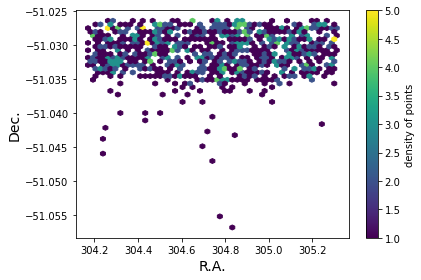

In [25]:
plt.figure()
plt.hexbin(data.RA, data.DEC, gridsize=50, mincnt=1) 
plt.xlabel("R.A.", fontsize=14)
plt.ylabel("Dec.", fontsize=14)
plt.colorbar(label="density of points")
plt.tight_layout()

### Magnitudes

In [26]:
from utils import get_photometric_columns
columns_list = get_photometric_columns(settings['bands'], settings['photo_type'], 
                                       settings['err_type'], settings['index'])
columns_list

['ID',
 'MAG_AUTO_G',
 'MAGERR_AUTO_G',
 'MAG_AUTO_R',
 'MAGERR_AUTO_R',
 'MAG_AUTO_I',
 'MAGERR_AUTO_I',
 'MAG_AUTO_Z',
 'MAGERR_AUTO_Z']

In [27]:
data.columns

Index(['RA', 'DEC', 'MAG_AUTO_G', 'MAG_AUTO_R', 'MAG_AUTO_I', 'MAG_AUTO_Z',
       'MAG_AUTO_Y', 'MAGERR_AUTO_G', 'MAGERR_AUTO_R', 'MAGERR_AUTO_I',
       'MAGERR_AUTO_Z', 'MAGERR_AUTO_Y', 'ID'],
      dtype='object')

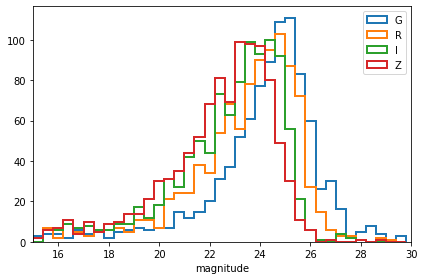

In [28]:
plt.figure()
for band in settings['bands']:
    mag = settings['photo_type'].format(band)
    query = mag + "< 40."
    plt.hist(data.query(query)[mag], histtype="step", bins=np.arange(15, 30, 0.4), label=band, lw=2)
plt.legend()
plt.xlabel("magnitude")
plt.xlim(15, 30)
plt.tight_layout()

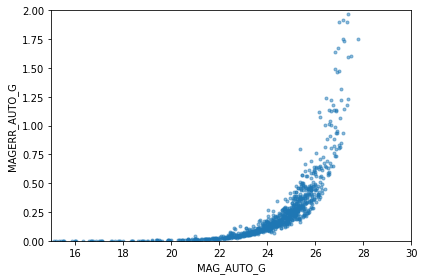

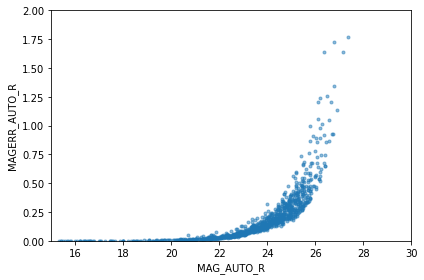

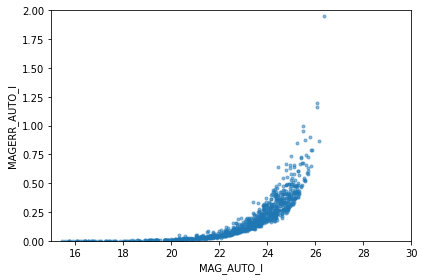

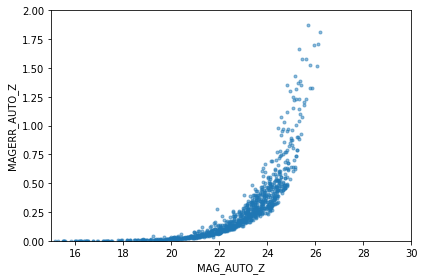

In [29]:
for band in settings['bands']:
    plt.figure()
    plt.plot(data[settings['photo_type'].format(band)],  
             data[settings['err_type'].format(band)], 
             ".", alpha=0.5)
    plt.xlim(15,30)
    plt.ylim(0,2)
    plt.xlabel(settings['photo_type'].format(band))    
    plt.ylabel(settings['err_type'].format(band))
    plt.tight_layout()

### Outputs  (LePhare results)

In [30]:
data_a = pd.read_parquet(output_paths[0])
data_b = pd.read_parquet(output_paths[1])
data_c = pd.read_parquet(output_paths[2])
data_d = pd.read_parquet(output_paths[3])
data_e = pd.read_parquet(output_paths[4])

In [31]:
photoz = pd.read_parquet(output_paths[0])
for i in range(1,5):
    photoz = pd.concat([photoz, pd.read_parquet(output_paths[i])])

In [32]:
photoz.head()

,ident,z_best,z_best68_low,z_best68_high,z_ml,pdz_best,id,err_z
0,1.0,0.58,0.0000,1.9294,0.6326,20.450,937,0.96470
1,2.0,2.00,1.0573,2.0000,1.3306,31.785,801,0.47135
2,3.0,0.68,0.6177,0.7165,0.6452,87.350,131,0.04940
3,4.0,0.00,0.0000,1.0222,0.4723,7.929,910,0.51110
4,5.0,0.00,0.0000,2.0000,1.2629,7.537,558,1.00000


In [33]:
photoz.describe()

,ident,z_best,z_best68_low,z_best68_high,z_ml,pdz_best,id,err_z
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,100.500000,0.664640,0.268407,1.072752,-1.166959,50.244187,500.500000,0.402173
std,57.763194,3.198689,3.166945,3.235969,13.627327,29.691690,288.819436,0.353159
min,1.000000,-99.000000,-99.000000,-99.000000,-99.000000,0.000000,1.000000,0.000000
25%,50.750000,0.420000,0.000000,0.609275,0.383700,25.382250,250.750000,0.086100
50%,100.500000,0.660000,0.220000,0.901600,0.680550,40.540500,500.500000,0.314225
75%,150.250000,0.960000,0.613850,2.000000,1.001700,74.057250,750.250000,0.632963
max,200.000000,2.000000,1.931200,2.000000,1.926200,100.831000,1000.000000,1.000000


### Redshift distribution 

#### Best fit photo-z

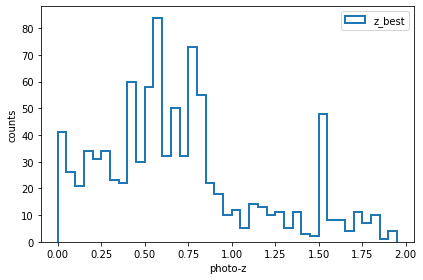

In [34]:
plt.figure()
plt.hist(photoz.z_best, histtype="step", label="z_best", lw=2,
         bins=np.arange(0, 2, 0.05))
plt.xlabel("photo-z")
plt.ylabel("counts")
plt.legend()
plt.tight_layout()

#### Maximum likelihood photo-z

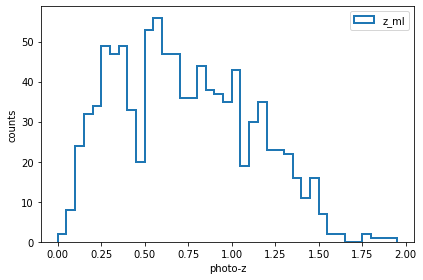

In [35]:
plt.figure()
plt.hist(photoz.z_ml, histtype="step", label="z_ml", lw=2,
         bins=np.arange(0, 2, 0.05))
plt.xlabel("photo-z")
plt.ylabel("counts")
plt.legend()
plt.tight_layout()

#### Photo-z errors

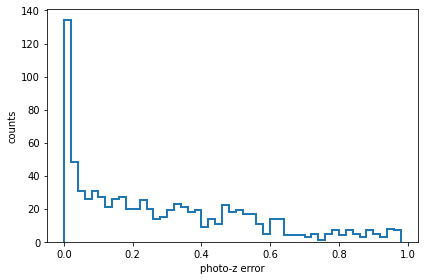

In [36]:
plt.figure()
plt.hist(photoz.err_z, histtype="step", lw=2,
         bins=np.arange(0, 1, 0.02))
plt.xlabel("photo-z error")
plt.ylabel("counts")
plt.tight_layout()

#### Best fit versus maximum likelihood photo-zs

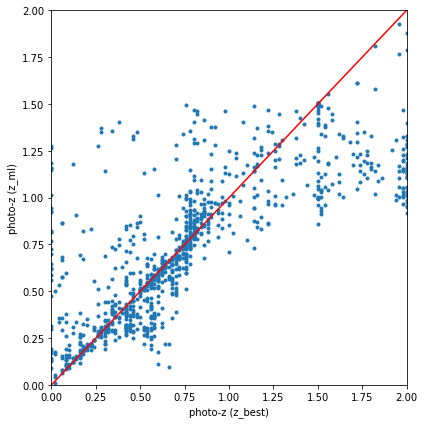

In [37]:
plt.figure(figsize=[6,6])
plt.plot(photoz.z_best, photoz.z_ml, ".")
plt.plot([-1, 3], [-1, 3], 'r-')
plt.xlabel("photo-z (z_best)")
plt.ylabel("photo-z (z_ml)")
plt.xlim(0., 2.)
plt.ylim(0., 2.)
plt.tight_layout()